# Anticipez les besoins en consommation électrique de bâtiments

Dans cette partie, nous allons procéder à diverses expérimentations afin de dégager des piste sur le modèle à chosir pour prédire au mieux nos données.

## Partie 2 - Prédictions & modélisations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time
import json
import requests
from scipy import spatial,stats
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
import seaborn as sns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from itertools import cycle
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn import dummy
from sklearn.utils import shuffle
from sklearn.linear_model import lasso_path, enet_path
from sklearn.svm import SVR
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import mlflow
import mlflow.sklearn
from xgboost import XGBRegressor
from boruta import BorutaPy
import shap

In [2]:
data_analyse = pd.read_csv('data/data_analyse.csv')

In [3]:
data_analyse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6652 entries, 0 to 6651
Data columns (total 61 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Unnamed: 0                                    6652 non-null   int64  
 1   NumberofBuildings                             6652 non-null   int64  
 2   NumberofFloors                                6652 non-null   int64  
 3   ENERGYSTARScore                               5070 non-null   float64
 4   Latitude                                      6652 non-null   float64
 5   Longitude                                     6652 non-null   float64
 6   BuildingType_Multifamily                      6652 non-null   int64  
 7   BuildingType_Nonresidential                   6652 non-null   int64  
 8   BuildingType_Sps-District K-12                6652 non-null   int64  
 9   Outlier_Lambda                                6652 non-null   i

In [4]:
data_analyse.head()

,Unnamed: 0,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Latitude,Longitude,BuildingType_Multifamily,BuildingType_Nonresidential,BuildingType_Sps-District K-12,Outlier_Lambda,Outlier_Low Outlier,PrimaryPropertyType_Education,PrimaryPropertyType_Food,PrimaryPropertyType_Healthcare,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Residential,PrimaryPropertyType_Science,PrimaryPropertyType_Store,LargestPropertyUseType_Education,LargestPropertyUseType_Food,LargestPropertyUseType_Healthcare,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Parking,LargestPropertyUseType_Public_Services,LargestPropertyUseType_Residential,LargestPropertyUseType_Science,LargestPropertyUseType_Store,SecondLargestPropertyUseType_Education,SecondLargestPropertyUseType_Food,SecondLargestPropertyUseType_Healthcare,SecondLargestPropertyUseType_Office,SecondLargestPropertyUseType_Other,SecondLargestPropertyUseType_Parking,SecondLargestPropertyUseType_Public_Services,SecondLargestPropertyUseType_Residential,SecondLargestPropertyUseType_Science,SecondLargestPropertyUseType_Store,ThirdLargestPropertyUseType_Education,ThirdLargestPropertyUseType_Food,ThirdLargestPropertyUseType_Healthcare,ThirdLargestPropertyUseType_Office,ThirdLargestPropertyUseType_Other,ThirdLargestPropertyUseType_Parking,ThirdLargestPropertyUseType_Public_Services,ThirdLargestPropertyUseType_Residential,ThirdLargestPropertyUseType_Science,ThirdLargestPropertyUseType_Store,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Age,RatioLargestUseGFA,RatioSecondUseGFA,RatioThirdUseGFA,SiteEnergyUseWN_log,GHGEmissions_log10
0,0,1,1,65.000,47.612,-122.338,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,88,1.000,0.000,0.000,15.775,2.397
1,1,1,1,51.000,47.613,-122.333,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,0.810,0.145,0.045,15.986,2.421
2,2,1,1,18.000,47.613,-122.338,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,46,0.787,0.104,0.000,18.140,3.314
3,3,1,1,1.000,47.614,-122.337,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,89,1.000,0.000,0.000,17.161,3.287
4,4,1,1,67.000,47.614,-122.341,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35,1.030,0.567,0.000,16.529,2.706


In [4]:
data_analyse.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
data_analyse = shuffle(data_analyse)

In [6]:
ESS = data_analyse['ENERGYSTARScore']

On retire l'energy score et on se le réserve pour la fin afin de comparer les résultats avec/sans

In [7]:
data_analyse.drop('ENERGYSTARScore', axis=1, inplace=True)

In [8]:
data_model = data_analyse.copy()
X = data_model.copy().drop(['SiteEnergyUseWN_log', 'GHGEmissions_log10',], axis=1)
Y = data_model.copy()[{'SiteEnergyUseWN_log', 'GHGEmissions_log10'}]

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y['SiteEnergyUseWN_log'], test_size = 0.2, random_state = 23)

In [10]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((5321, 57), (5321,), (1331, 57), (1331,))

# Etude de la consomation d'Energie

## Création d'une Baseline via une mediane

In [11]:
dummy_model = make_pipeline(RobustScaler(),dummy.DummyRegressor(strategy='median'))
rmse_lr=np.abs(cross_val_score(dummy_model, X_train , Y_train, cv=5, scoring='neg_mean_squared_error').mean())
print('RMSE Mediane',rmse_lr)

RMSE Mediane 1.3055469739807926


In [70]:
lm = LinearRegression().fit(X_train, Y_train)
lm_dummy_mean = dummy.DummyRegressor(strategy = 'mean').fit(X_train, Y_train)
lm_dummy_median = dummy.DummyRegressor(strategy = 'median').fit(X_train, Y_train)
y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

[1.26316239 1.41378188 1.58854593 ... 1.31941062 1.20661609 1.1806839 ]


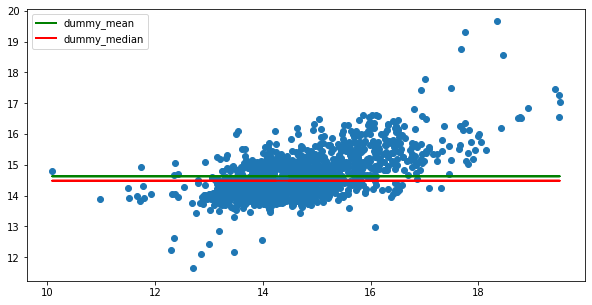

In [13]:
plt.scatter(Y_test, y_predict)
plt.plot(Y_test, y_predict_dummy_mean,color='green', 
         linewidth=2, label = 'dummy_mean')
plt.plot(Y_test, y_predict_dummy_median,color='red', 
         linewidth=2, label = 'dummy_median')
plt.legend()

## Standartisation

On utilisera la méthode RobustScaler pour nos données quantifiées

In [14]:
X_train.columns

Index(['NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude',
       'BuildingType_Multifamily', 'BuildingType_Nonresidential',
       'BuildingType_Sps-District K-12', 'Outlier_Lambda',
       'Outlier_Low Outlier', 'PrimaryPropertyType_Education',
       'PrimaryPropertyType_Food', 'PrimaryPropertyType_Healthcare',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Residential', 'PrimaryPropertyType_Science',
       'PrimaryPropertyType_Store', 'LargestPropertyUseType_Education',
       'LargestPropertyUseType_Food', 'LargestPropertyUseType_Healthcare',
       'LargestPropertyUseType_Office', 'LargestPropertyUseType_Other',
       'LargestPropertyUseType_Parking',
       'LargestPropertyUseType_Public_Services',
       'LargestPropertyUseType_Residential', 'LargestPropertyUseType_Science',
       'LargestPropertyUseType_Store',
       'SecondLargestPropertyUseType_Education',
       'SecondLargestPropertyUseType_Food',
       'Secon

In [15]:
X_train_numerical =X_train[['NumberofBuildings','NumberofFloors','Latitude','Longitude','Age' , 'RatioLargestUseGFA','RatioSecondUseGFA', 'RatioThirdUseGFA']].columns 
X_test_numerical =X_test[['NumberofBuildings','NumberofFloors','Latitude','Longitude','Age' , 'RatioLargestUseGFA','RatioSecondUseGFA', 'RatioThirdUseGFA']].columns 

In [16]:
scaler = RobustScaler()
X_train[X_train_numerical] = scaler.fit_transform(X_train[X_train_numerical])
X_test[X_test_numerical] = scaler.transform(X_test[X_test_numerical])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

On commence par tester un outil de gestion de workflow et de ML appelé MLFLOW. 
Celui ci permet de stocker les résultats de chaque expérimentations et de voir les meilleurs résultats. 

ATTENTION : MLFLOW n'est pas fonctionnelle sous WINDOWS

## ElasticNet

In [17]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [18]:
list_alpha= [0.0001, 0.001, 0.01,0.05, 0.1, 1, 10, 100]
list_l1_ratio = [.1, .5, .7, .9, .95, .99, 1]

In [19]:
def exec_mlflow(alpha, l1_ratio, name, target):
    time_start= time.time()
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(X_train, Y_train)
    predicted_qualities = lr.predict(X_test)
    (rmse, mae, r2) = eval_metrics(Y_test, predicted_qualities)
    time_end = time.time()
    time_exec = time_end - time_start
    # Print out ElasticNet model metrics
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("  Time: %s" % time_exec)
    # Log mlflow attributes for mlflow UI
    with mlflow.start_run(run_name = name) as mlrun:
        
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("Time", time_exec)
        mlflow.sklearn.log_model(lr,name)
        eps = 5e-3  # the smaller it is the longer is the path

        print("Computing regularization path using the elastic net.")
        alphas_lasso, coefs_lasso, _ = lasso_path(X, target, eps=eps, fit_intercept=False)
        alphas_enet, coefs_enet, _ = enet_path(X, target, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)
        alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(X, target, eps=eps, positive=True, fit_intercept=False)
        alphas_positive_enet, coefs_positive_enet, _ = enet_path( X, target, eps=eps, l1_ratio=l1_ratio, positive=True, fit_intercept=False)
        # Display results
        fig = plt.figure(1)
        colors = cycle(['b', 'r', 'g', 'c', 'k'])
        neg_log_alphas_lasso = -np.log10(alphas_lasso)
        neg_log_alphas_enet = -np.log10(alphas_enet)
        neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
        for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
            l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
            l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

        plt.xlabel('-Log(alpha)')
        plt.ylabel('coefficients')
        plt.title('Elastic-Net and positive Elastic-Net')
        plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
                   loc='lower left')
        plt.axis('tight')
        fig.savefig("ElasticNet-paths.png")
        plt.close(fig)
        mlflow.log_artifact("ElasticNet-paths.png")
        mlflow.end_run()

In [20]:
for a in list_alpha:
    for l1 in list_l1_ratio:
        exec_mlflow(a, l1,"ElasticNet", Y['SiteEnergyUseWN_log'])

2021/08/04 06:23:50 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Elasticnet model (alpha=0.000100, l1_ratio=0.100000):
  RMSE: 0.9076475631247242
  MAE: 0.7035121474150421
  R2: 0.4041784760304057
  Time: 0.1696016788482666
Computing regularization path using the elastic net.
Elasticnet model (alpha=0.000100, l1_ratio=0.500000):
  RMSE: 0.9075364940076832
  MAE: 0.7033490996063783
  R2: 0.4043242888418911
  Time: 0.1901547908782959
Computing regularization path using the elastic net.
Elasticnet model (alpha=0.000100, l1_ratio=0.700000):
  RMSE: 0.9074406032234443
  MAE: 0.7032178886767843
  R2: 0.40445016101081754
  Time: 0.15125393867492676
Computing regularization path using the elastic net.
Elasticnet model (alpha=0.000100, l1_ratio=0.900000):
  RMSE: 0.9073521305613956
  MAE: 0.7030737709023201
  R2: 0.4045662838973192
  Time: 0.12226605415344238
Computing regularization path using the elastic net.
Elasticnet model (alpha=0.000100, l1_ratio=0.950000):
  RMSE: 0.9073322505872126
  MAE: 0.7030349187186108
  R2: 0.40459237537124504
  Time: 0.132832

Elasticnet model (alpha=1.000000, l1_ratio=0.950000):
  RMSE: 1.1760579962775555
  MAE: 0.912681660070035
  R2: -0.000320511944313262
  Time: 0.013368368148803711
Computing regularization path using the elastic net.
Elasticnet model (alpha=1.000000, l1_ratio=0.990000):
  RMSE: 1.1760579962775555
  MAE: 0.912681660070035
  R2: -0.000320511944313262
  Time: 0.029471158981323242
Computing regularization path using the elastic net.
Elasticnet model (alpha=1.000000, l1_ratio=1.000000):
  RMSE: 1.1760579962775555
  MAE: 0.912681660070035
  R2: -0.000320511944313262
  Time: 0.017838478088378906
Computing regularization path using the elastic net.
Elasticnet model (alpha=10.000000, l1_ratio=0.100000):
  RMSE: 1.1760579962775555
  MAE: 0.912681660070035
  R2: -0.000320511944313262
  Time: 0.012401103973388672
Computing regularization path using the elastic net.
Elasticnet model (alpha=10.000000, l1_ratio=0.500000):
  RMSE: 1.1760579962775555
  MAE: 0.912681660070035
  R2: -0.000320511944313262


MLFLOW UI permet d'avoir acces au dashboard regroupant les infos de chaque exectuions et de les récuperer sous forme d'API

In [22]:
# %%bash 
# mlflow ui &

In [21]:
def get_run_mlflow(model):
    data = {"experiment_ids":["0"],"filter":"tags.\"mlflow.runName\" ='"+model+"'","run_view_type":"ACTIVE_ONLY","max_results":100,"order_by":[]}
    r = requests.post('http://127.0.0.1:5000/ajax-api/2.0/preview/mlflow/runs/search', data=json.dumps(data))
    data_runs=pd.DataFrame(columns = ['Run_id','parameters','R2' ,'RMSE' , 'MAE', 'Temps' ])
    for run in r.json()['runs']:
        run_id = run['info']['run_id']
        parameters=[]
        for param in run['data']['params']:
            parameters.append(param['key'] +' : ' + param['value'],)
        r2 = run['data']['metrics'][0]['value']
        rmse = run['data']['metrics'][1]['value']
        temps = run['data']['metrics'][2]['value']
        mae = run['data']['metrics'][3]['value']
        data_runs = data_runs.append({'Run_id':run_id,'parameters':parameters,
        'R2':r2  ,'RMSE': rmse, 'MAE':mae,    'Temps':temps }, ignore_index=True)
    return data_runs

In [22]:
Elastic = get_run_mlflow("ElasticNet")

Obtenir le meilleur résultat ELASTICNET

In [23]:
Elastic.sort_values(by=['RMSE','Temps'],ascending=[True, True]).head(1)

,Run_id,parameters,R2,RMSE,MAE,Temps
99,0c0b51bd75cf4ac28c270724c13aff33,"[l1_ratio : 0.99, alpha : 0.001]",0.404,0.901,0.695,0.119


## SVR

In [24]:
#pour mesurer le temps
deb_svr = time.time()
# Define the model
svr= SVR()

#Fit the model
svr.fit(X_train,Y_train)

#Predicting using test set
y_pred=svr.predict(X_test)
#time à la fin
fin_svr = time.time()

# Metrics
mae_svr = mean_absolute_error(Y_test, y_pred)
mse_svr = mean_squared_error(Y_test, y_pred)
r2_svr = r2_score(Y_test, y_pred)
rmse_svr = sqrt(mse_svr)

#durée d'exécution
time_svr = fin_svr - deb_svr

In [25]:
print("MAE : ",mae_svr, "R2:",r2_svr,"RMSE: ",rmse_svr,"temps : ",time_svr)

MAE :  0.616647104282184 R2: 0.4974360700313628 RMSE:  0.8335944406141278 temps :  1.1630001068115234


In [26]:
scores = cross_val_score(svr, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE SVR',np.abs(scores.mean()))

RMSE SVR 0.6839860181909524


## Arbre de décision

In [27]:
#pour mesurer le temps
deb_dt = time.time()
# Define the model
dt = DecisionTreeRegressor(random_state = 0)

# Fit the model
dt.fit(X_train,Y_train)
#Predicting using test set 
y_pred = dt.predict(X_test)
#time à la fin
fin_dt = time.time()

# Printing the metrics
mae_dt = mean_absolute_error(Y_test, y_pred)
mse_dt = mean_squared_error(Y_test, y_pred)
r2_dt = r2_score(Y_test, y_pred)
rmse_dt = sqrt(mse_dt)

#durée d'exécution
time_dt = fin_dt - deb_dt

In [28]:
print("MAE : ",mae_dt, "R2:",r2_dt,"RMSE: ",rmse_dt,"temps : ",time_dt)

MAE :  0.5101752020498819 R2: 0.4856491121733729 RMSE:  0.8433132013597069 temps :  0.0394597053527832


In [29]:
scores = cross_val_score(dt, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE DT',np.abs(scores.mean()))

RMSE DT 0.8926474996948425


## RANDOM FOREST

In [30]:
#pour mesurer le temps
deb_rf = time.time()
# Define the model
rf = RandomForestRegressor(n_estimators = 200 ,  random_state = 0)

# Fit the model
rf.fit(X_train,Y_train)

#Predicting using test set 
y_pred = rf.predict(X_test)
#time à la fin
fin_rf = time.time()

# Printing the metrics
mae_rf = mean_absolute_error(Y_test, y_pred)
mse_rf = mean_squared_error(Y_test, y_pred)
r2_rf = r2_score(Y_test, y_pred)
rmse_rf = sqrt(mse_rf)

#durée d'exécution
time_rf = fin_rf - deb_rf

In [31]:
print("MAE : ",mae_rf, "R2:",r2_rf,"RMSE: ",rmse_rf,"temps : ",time_rf)

MAE :  0.4849587411723104 R2: 0.6669785537557824 RMSE:  0.6785709342772506 temps :  4.091128349304199


In [32]:
scores = cross_val_score(rf, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE RF',np.abs(scores.mean()))

RMSE RF 0.5107129138749826


## xgboost

In [33]:
#pour mesurer le temps
deb_xgb = time.time()
# Define the model
xgb = XGBRegressor()

# Fit the model
xgb.fit(X_train, Y_train)

#Predicting using test set
y_pred = xgb.predict(X_test)
#time à la fin
fin_xgb = time.time()

# Printing the metrics
mae_xgb = mean_absolute_error(Y_test, y_pred)
mse_xgb = mean_squared_error(Y_test, y_pred)
r2_xgb = r2_score(Y_test, y_pred)
rmse_xgb = sqrt(mse_xgb)

#durée d'exécution
time_xgb = fin_xgb - deb_xgb

In [34]:
print("MAE : ",mae_xgb, "R2:",r2_xgb,"RMSE: ",rmse_xgb,"temps : ",time_xgb)

MAE :  0.516470980162501 R2: 0.6346368494676219 RMSE:  0.7107576188915796 temps :  0.5263795852661133


In [35]:
scores = cross_val_score(xgb, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE XGB',np.abs(scores.mean()))

RMSE XGB 0.5340469666509089


In [36]:
rmse_elastic = Elastic.sort_values(by=['RMSE','Temps'],ascending=[True, True]).head(1).RMSE.values[0]
time_elastic=Elastic.sort_values(by=['RMSE','Temps'],ascending=[True, True]).head(1).Temps.values[0]
resultat = pd.DataFrame({
    'Modèle' : ['Rég. linéaire Non_Régu','ElasticNEt','SVR','Decision_Tree','RandomForest','XGBoost'],
    'RMSE' : [rmse_lr,rmse_elastic,rmse_svr,rmse_dt,rmse_rf,rmse_xgb],
    'Temps' : [0.0,time_elastic,time_svr,time_dt,time_rf,time_xgb]})

In [37]:
resultat

,Modèle,RMSE,Temps
0,Rég. linéaire Non_Régu,1.306,0.000
1,ElasticNEt,0.901,0.119
2,SVR,0.834,1.163
3,Decision_Tree,0.843,0.039
4,RandomForest,0.679,4.091
5,XGBoost,0.711,0.526


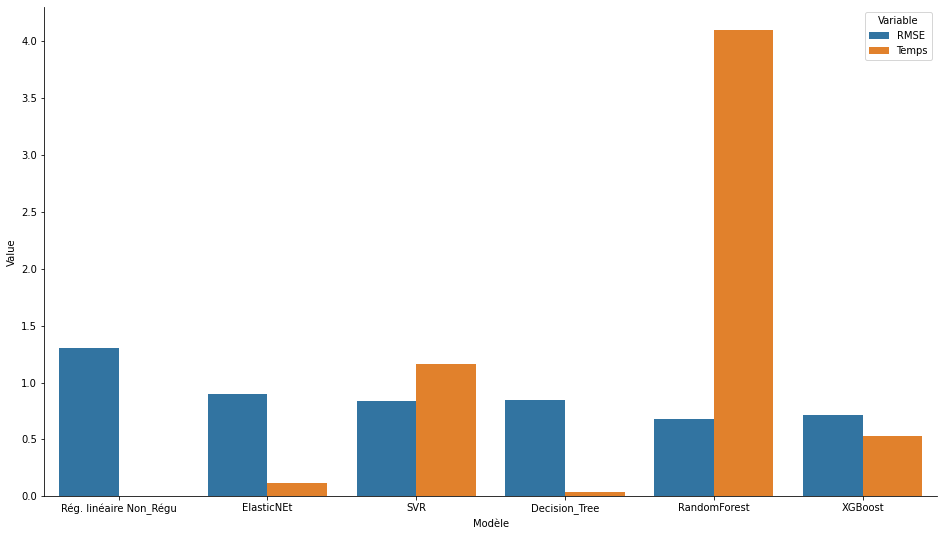

In [38]:
fig, ax1 = plt.subplots(figsize=(16, 9))
tidy = resultat.melt(id_vars='Modèle').rename(columns=str.title)
sns.barplot(x='Modèle', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

## Feature Selection

Afin d'optimiser nos résultats, on va utiliser l'outil Boruta qui permet de clalculer les features les plus intéressantes et nécessaires sur nos dataset

In [17]:
clf = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=5)

trans = BorutaPy(clf, random_state=42, verbose=2)
sel = trans.fit_transform(X.values, Y['SiteEnergyUseWN_log'].values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	40
Iteration: 	9 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	40
Iteration: 	10 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	40
Iteration: 	11 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	40
Iteration: 	12 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	40
Iteration: 	13 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	40
Iteration: 	14 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	40
Iteration: 	15 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	40
Iteration: 	16 / 100
Confirmed: 	16
Tentative: 	1
Reject

In [41]:
trans.ranking_

array([ 3,  1,  1,  1,  1,  1, 39,  2,  1, 27, 18,  1, 18, 11,  7,  1, 39,
        4, 10,  1, 13, 15, 35, 32,  1,  5, 39, 39, 20, 25,  9, 34,  1, 39,
        6, 24,  8, 33, 26, 36, 28, 21, 17, 39, 30, 22, 13, 30, 11, 23, 29,
       16,  1,  1,  1,  1,  1])

In [21]:
feature_df = pd.DataFrame(X.columns.tolist(), columns=['features'])
feature_df['rank']=trans.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % trans.n_features_)
print (feature_df.head(trans.n_features_))


 Top 16 features:
                                features  rank
0                       RatioThirdUseGFA     1
1     LargestPropertyUseType_Residential     1
2                      RatioSecondUseGFA     1
3   SecondLargestPropertyUseType_Parking     1
4         PrimaryPropertyType_Healthcare     1
5                  CouncilDistrictCode_7     1
6                                    Age     1
7            PrimaryPropertyType_Science     1
8                    Outlier_Low Outlier     1
9                     RatioLargestUseGFA     1
10           BuildingType_Nonresidential     1
11              BuildingType_Multifamily     1
12                             Longitude     1
13                              Latitude     1
14                        NumberofFloors     1
15     LargestPropertyUseType_Healthcare     1


In [22]:
features = feature_df.head(trans.n_features_)['features'].values.tolist()

## Tester uniquement avec les variables séléctionnées par boruta

On utilisera l'algorithme RandomForest et XgBoost afin de comparer nos valeurs

In [23]:
X_train_boruta= X_train[features].copy()
X_test_boruta= X_test[features].copy()

### RANDOM FOREST 

In [91]:
resultat[resultat['Modèle']=='RandomForest']

,Modèle,RMSE,Temps
4,RandomForest,0.691,6.296


In [93]:
#pour mesurer le temps
deb_rf = time.time()
# Define the model
rf = RandomForestRegressor(n_estimators = 200 ,  random_state = 0)

# Fit the model
rf.fit(X_train_boruta,Y_train)

#Predicting using test set 
y_pred = rf.predict(X_test_boruta)
#time à la fin
fin_rf = time.time()

# Printing the metrics
mae_rf = mean_absolute_error(Y_test, y_pred)
mse_rf = mean_squared_error(Y_test, y_pred)
r2_rf = r2_score(Y_test, y_pred)
rmse_rf = sqrt(mse_rf)

#durée d'exécution
time_rf = fin_rf - deb_rf

In [94]:
print("RMSE: ",rmse_rf,"temps : ",time_rf)

RMSE:  0.708028295266033 temps :  4.259933948516846


Sur les tests : 

| AVANT/APRES  | RMSE          | TEMPS |
| :--------------- |:---------------:| -----:|
| Avant  |    0.691       |  6.296 |
| Apres  | 0.708 |  4.259 |


In [101]:
scores = cross_val_score(rf, X_train_boruta, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE RF',np.abs(scores.mean()))

RMSE RF 0.534925786900694


Cross-validation : 


RMSE RF avant : 0.5155602595091315

RMSE RF après : 0.534925786900694

### XGBOOST

In [95]:
resultat[resultat['Modèle']=='XGBoost']

,Modèle,RMSE,Temps
5,XGBoost,0.718,0.489


In [96]:
#pour mesurer le temps
deb_xgb = time.time()
# Define the model
xgb = XGBRegressor()

# Fit the model
xgb.fit(X_train_boruta, Y_train)

#Predicting using test set
y_pred = xgb.predict(X_test_boruta)
#time à la fin
fin_xgb = time.time()

# Printing the metrics
mae_xgb = mean_absolute_error(Y_test, y_pred)
mse_xgb = mean_squared_error(Y_test, y_pred)
r2_xgb = r2_score(Y_test, y_pred)
rmse_xgb = sqrt(mse_xgb)

#durée d'exécution
time_xgb = fin_xgb - deb_xgb

In [97]:
print("RMSE: ",rmse_xgb,"temps : ",time_xgb)

RMSE:  0.7550501016897216 temps :  0.4496283531188965


Sur les tests : 

| AVANT/APRES  | RMSE          | TEMPS |
| :--------------- |:---------------:| -----:|
| Avant  |   0.718        |  0.489 |
| Apres  |	0.755 |  0.449 |


In [100]:
scores = cross_val_score(xgb, X_train_boruta, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE XGB',np.abs(scores.mean()))

RMSE XGB 0.5661068119109591


Cross-validation :

RMSE XGB  avant : 0.5272627846501032

RMSE XGB  après : 0.5661068119109591


Boruta a permis d'augmenter le temps pour notre algorithme RandomForest en n'effectuant qu'une legere hausse de notre RMSE. 
Tandis que sur l'algorithme XGBoost celui ci a augmenté significativement pour un même temps d'éxecution

## Recherche des meilleurs paramètres via Gridsearch

In [30]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [ 14, 15, 16],
    'n_estimators': [50, 100, 200, 300, 400, 500]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='neg_mean_squared_error', cv = 3, n_jobs = -1, verbose = 0)

In [31]:
grid_search.fit(X_train_boruta, Y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [30, 40, 50, 60],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [14, 15, 16],
                         'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error')

In [136]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 400}

In [137]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=14,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [138]:
#pour mesurer le temps
deb_rf = time.time()
# Define the model
rf = RandomForestRegressor(bootstrap= True, 
                           max_depth= 50, min_samples_leaf= 1,
                           min_samples_split= 14, n_estimators= 400)

# Fit the model
rf.fit(X_train_boruta,Y_train)

#Predicting using test set 
y_pred = rf.predict(X_test_boruta)
#time à la fin
fin_rf = time.time()

# Printing the metrics
mae_rf = mean_absolute_error(Y_test, y_pred)
mse_rf = mean_squared_error(Y_test, y_pred)
r2_rf = r2_score(Y_test, y_pred)
rmse_rf = sqrt(mse_rf)

#durée d'exécution
time_rf = fin_rf - deb_rf

In [139]:
print("RMSE: ",rmse_rf,"temps : ",time_rf)

RMSE:  0.7663961561846482 temps :  6.291978597640991


Sur les tests : 

| AVANT/APRES  | RMSE          | TEMPS |
| :--------------- |:---------------:| -----:|
| Avant boruta  |    0.691       |  6.296 |
| Apres boruta | 0.708 |  4.259 |
| GridSearch  | 0.767  |  6.291 |

In [140]:
scores = cross_val_score(rf, X_train_boruta, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE RF',np.abs(scores.mean()))

RMSE RF 0.5913795901680989


Text(0, 0.5, 'y_pred')

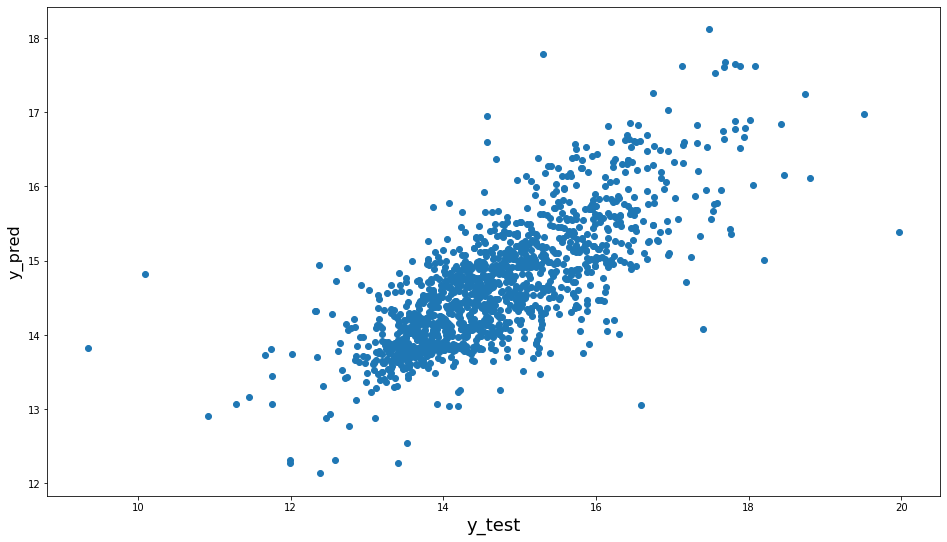

In [170]:
plt.figure(figsize=(16,9))
plt.scatter(Y_test, y_pred)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

Text(0, 0.5, 'y_pred')

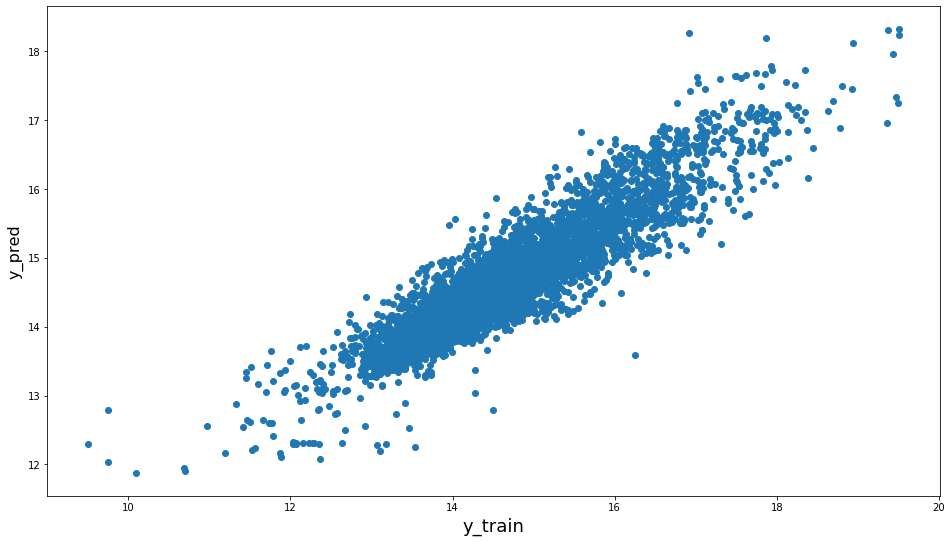

In [168]:
plt.figure(figsize=(16,9))
plt.scatter(Y_train, rf.predict(X_train_boruta))
plt.xlabel('y_train', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

In [145]:
coefficients = abs(grid_search.best_estimator_.feature_importances_)
liste_coefs = pd.concat((pd.DataFrame(X_train_boruta.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

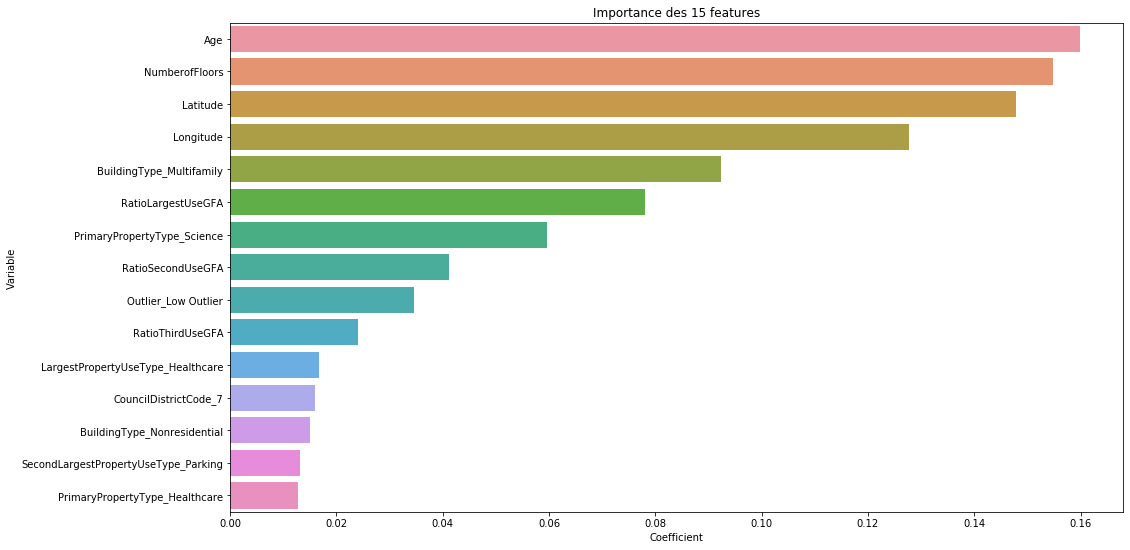

In [146]:
plt.figure(figsize=(16,9))
plt.title('Importance des 15 features')
sns.barplot(y = liste_coefs['Variable'].head(15),
            x = liste_coefs['Coefficient'].head(15))
plt.show()

On retrovue les memes valeurs que Boruta ce qui est rassurant

## Shape Value 

In [150]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_boruta)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_boruta.iloc[0,:])

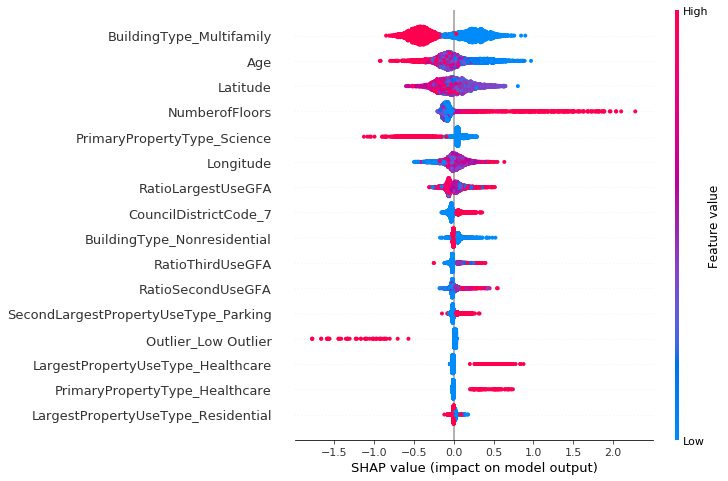

In [152]:
shap.summary_plot(shap_values, X_train_boruta)

  # Etude de l'émission CO2

On change notre target Y pour celle des émissions de C02 et on refait les memes procédures qu'avant

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y['GHGEmissions_log10'], test_size = 0.2, random_state = 23)

In [40]:
dummy_model = make_pipeline(RobustScaler(),dummy.DummyRegressor(strategy='median'))
rmse_lr=np.abs(cross_val_score(dummy_model, X_train , Y_train, cv=5, scoring='neg_mean_squared_error').mean())
print('RMSE Mediane',rmse_lr)

RMSE Mediane 0.4217617261540898


In [71]:
lm = LinearRegression().fit(X_train, Y_train)
lm_dummy_mean = dummy.DummyRegressor(strategy = 'mean').fit(X_train, Y_train)
lm_dummy_median = dummy.DummyRegressor(strategy = 'median').fit(X_train, Y_train)
y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

array([1.26316239, 1.41378188, 1.58854593, ..., 1.31941062, 1.20661609,
       1.1806839 ])

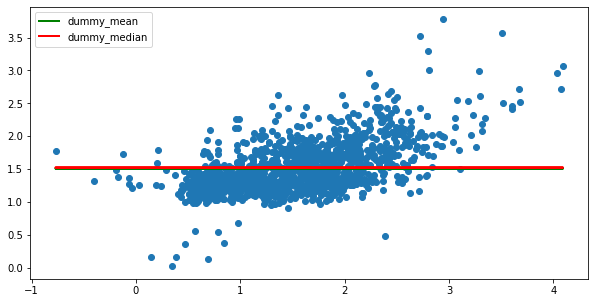

In [42]:
plt.scatter(Y_test, y_predict)
plt.plot(Y_test, y_predict_dummy_mean,color='green', 
         linewidth=2, label = 'dummy_mean')
plt.plot(Y_test, y_predict_dummy_median,color='red', 
         linewidth=2, label = 'dummy_median')
plt.legend()

## Standartisation

In [43]:
X_train.columns

Index(['NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude',
       'BuildingType_Multifamily', 'BuildingType_Nonresidential',
       'BuildingType_Sps-District K-12', 'Outlier_Lambda',
       'Outlier_Low Outlier', 'PrimaryPropertyType_Education',
       'PrimaryPropertyType_Food', 'PrimaryPropertyType_Healthcare',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Residential', 'PrimaryPropertyType_Science',
       'PrimaryPropertyType_Store', 'LargestPropertyUseType_Education',
       'LargestPropertyUseType_Food', 'LargestPropertyUseType_Healthcare',
       'LargestPropertyUseType_Office', 'LargestPropertyUseType_Other',
       'LargestPropertyUseType_Parking',
       'LargestPropertyUseType_Public_Services',
       'LargestPropertyUseType_Residential', 'LargestPropertyUseType_Science',
       'LargestPropertyUseType_Store',
       'SecondLargestPropertyUseType_Education',
       'SecondLargestPropertyUseType_Food',
       'Secon

In [44]:
X_train_numerical =X_train[['NumberofBuildings','NumberofFloors','Latitude','Longitude','Age' , 'RatioLargestUseGFA','RatioSecondUseGFA', 'RatioThirdUseGFA']].columns 
X_test_numerical =X_test[['NumberofBuildings','NumberofFloors','Latitude','Longitude','Age' , 'RatioLargestUseGFA','RatioSecondUseGFA', 'RatioThirdUseGFA']].columns 

In [45]:
scaler = RobustScaler()
X_train[X_train_numerical] = scaler.fit_transform(X_train[X_train_numerical])
X_test[X_test_numerical] = scaler.transform(X_test[X_test_numerical])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

## ElasticNet

In [46]:
# Evaluate metrics
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [47]:
list_alpha= [0.0001, 0.001, 0.01,0.05, 0.1, 1, 10, 100]
list_l1_ratio = [.1, .5, .7, .9, .95, .99, 1]

In [48]:
for a in list_alpha:
    for l1 in list_l1_ratio:
        exec_mlflow(a, l1,"ElasticNet_emission", Y['GHGEmissions_log10'])

Elasticnet model (alpha=0.000100, l1_ratio=0.100000):
  RMSE: 0.5422951501655016
  MAE: 0.44103244898121025
  R2: 0.3424657387309674
  Time: 0.1578807830810547
Computing regularization path using the elastic net.
Elasticnet model (alpha=0.000100, l1_ratio=0.500000):
  RMSE: 0.542291700161914
  MAE: 0.4409176209727376
  R2: 0.34247410498076225
  Time: 0.17430472373962402
Computing regularization path using the elastic net.
Elasticnet model (alpha=0.000100, l1_ratio=0.700000):
  RMSE: 0.542296334837647
  MAE: 0.44085260062608983
  R2: 0.3424628658917963
  Time: 0.1147773265838623
Computing regularization path using the elastic net.
Elasticnet model (alpha=0.000100, l1_ratio=0.900000):
  RMSE: 0.5423084377748011
  MAE: 0.440787726415378
  R2: 0.3424335158154491
  Time: 0.12636303901672363
Computing regularization path using the elastic net.
Elasticnet model (alpha=0.000100, l1_ratio=0.950000):
  RMSE: 0.5423113140938326
  MAE: 0.44077148982517117
  R2: 0.34242654053762944
  Time: 0.145410

Elasticnet model (alpha=1.000000, l1_ratio=0.950000):
  RMSE: 0.6688154632210287
  MAE: 0.5432090052220993
  R2: -0.00013714475984971664
  Time: 0.014527320861816406
Computing regularization path using the elastic net.
Elasticnet model (alpha=1.000000, l1_ratio=0.990000):
  RMSE: 0.6688154632210287
  MAE: 0.5432090052220993
  R2: -0.00013714475984971664
  Time: 0.01297140121459961
Computing regularization path using the elastic net.
Elasticnet model (alpha=1.000000, l1_ratio=1.000000):
  RMSE: 0.6688154632210287
  MAE: 0.5432090052220993
  R2: -0.00013714475984971664
  Time: 0.012174129486083984
Computing regularization path using the elastic net.
Elasticnet model (alpha=10.000000, l1_ratio=0.100000):
  RMSE: 0.6688154632210287
  MAE: 0.5432090052220993
  R2: -0.00013714475984971664
  Time: 0.012966394424438477
Computing regularization path using the elastic net.
Elasticnet model (alpha=10.000000, l1_ratio=0.500000):
  RMSE: 0.6688154632210287
  MAE: 0.5432090052220993
  R2: -0.0001371

In [49]:
Elastic = get_run_mlflow("ElasticNet_emission")

In [54]:
Elastic.sort_values(by=['RMSE','Temps'],ascending=[True, True]).head(1)

,Run_id,parameters,R2,RMSE,MAE,Temps
54,aa54e96b4fc34c0cacdd83e055e9125c,"[l1_ratio : 0.5, alpha : 0.0001]",0.342,0.542,0.441,0.174


## SVR

In [55]:
#pour mesurer le temps
deb_svr = time.time()
# Define the model
svr= SVR()

#Fit the model
svr.fit(X_train,Y_train)

#Predicting using test set
y_pred=svr.predict(X_test)
#time à la fin
fin_svr = time.time()

# Metrics
mae_svr = mean_absolute_error(Y_test, y_pred)
mse_svr = mean_squared_error(Y_test, y_pred)
r2_svr = r2_score(Y_test, y_pred)
rmse_svr = sqrt(mse_svr)

#durée d'exécution
time_svr = fin_svr - deb_svr

In [56]:
print("MAE : ",mae_svr, "R2:",r2_svr,"RMSE: ",rmse_svr,"temps : ",time_svr)

MAE :  0.3802803449374217 R2: 0.4525742061300223 RMSE:  0.4948107831739489 temps :  1.1011958122253418


In [57]:
scores = cross_val_score(svr, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE SVR',np.abs(scores.mean()))

RMSE SVR 0.24419031736017938


## Arbre de décision

In [58]:
#pour mesurer le temps
deb_dt = time.time()
# Define the model
dt = DecisionTreeRegressor(random_state = 0)

# Fit the model
dt.fit(X_train,Y_train)
#Predicting using test set 
y_pred = dt.predict(X_test)
#time à la fin
fin_dt = time.time()

# Printing the metrics
mae_dt = mean_absolute_error(Y_test, y_pred)
mse_dt = mean_squared_error(Y_test, y_pred)
r2_dt = r2_score(Y_test, y_pred)
rmse_dt = sqrt(mse_dt)

#durée d'exécution
time_dt = fin_dt - deb_dt

In [59]:
print("MAE : ",mae_dt, "R2:",r2_dt,"RMSE: ",rmse_dt,"temps : ",time_dt)

MAE :  0.32277727185923566 R2: 0.35963059241419837 RMSE:  0.535170067615009 temps :  0.03479576110839844


In [60]:
scores = cross_val_score(dt, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE DT',np.abs(scores.mean()))

RMSE DT 0.29401691118300255


## RANDOM FOREST

In [61]:
#pour mesurer le temps
deb_rf = time.time()
# Define the model
rf = RandomForestRegressor(n_estimators = 200 ,  random_state = 0)

# Fit the model
rf.fit(X_train,Y_train)

#Predicting using test set 
y_pred = rf.predict(X_test)
#time à la fin
fin_rf = time.time()

# Printing the metrics
mae_rf = mean_absolute_error(Y_test, y_pred)
mse_rf = mean_squared_error(Y_test, y_pred)
r2_rf = r2_score(Y_test, y_pred)
rmse_rf = sqrt(mse_rf)

#durée d'exécution
time_rf = fin_rf - deb_rf

In [62]:
print("MAE : ",mae_rf, "R2:",r2_rf,"RMSE: ",rmse_rf,"temps : ",time_rf)

MAE :  0.2940835183135798 R2: 0.6373978961937097 RMSE:  0.40270932562310113 temps :  3.922964334487915


In [63]:
scores = cross_val_score(rf, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE RF',np.abs(scores.mean()))

RMSE RF 0.17398802886076611


## xgboost

In [64]:
#pour mesurer le temps
deb_xgb = time.time()
# Define the model
xgb = XGBRegressor()

# Fit the model
xgb.fit(X_train, Y_train)

#Predicting using test set
y_pred = xgb.predict(X_test)
#time à la fin
fin_xgb = time.time()

# Printing the metrics
mae_xgb = mean_absolute_error(Y_test, y_pred)
mse_xgb = mean_squared_error(Y_test, y_pred)
r2_xgb = r2_score(Y_test, y_pred)
rmse_xgb = sqrt(mse_xgb)

#durée d'exécution
time_xgb = fin_xgb - deb_xgb

In [65]:
print("MAE : ",mae_xgb, "R2:",r2_xgb,"RMSE: ",rmse_xgb,"temps : ",time_xgb)

MAE :  0.3149588687255645 R2: 0.5988870795818566 RMSE:  0.4235550388604769 temps :  0.474942684173584


In [66]:
scores = cross_val_score(xgb, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE XGB',np.abs(scores.mean()))

RMSE XGB 0.18868756294293917


In [67]:
rmse_elastic = Elastic.sort_values(by=['RMSE','Temps'],ascending=[True, True]).head(1).RMSE.values[0]
time_elastic=Elastic.sort_values(by=['RMSE','Temps'],ascending=[True, True]).head(1).Temps.values[0]
resultat = pd.DataFrame({
    'Modèle' : ['Rég. linéaire Non_Régu','ElasticNEt','SVR','Decision_Tree','RandomForest','XGBoost'],
    'RMSE' : [rmse_lr,rmse_elastic,rmse_svr,rmse_dt,rmse_rf,rmse_xgb],
    'Temps' : [0.0,time_elastic,time_svr,time_dt,time_rf,time_xgb]})

In [68]:
resultat

,Modèle,RMSE,Temps
0,Rég. linéaire Non_Régu,0.422,0.000
1,ElasticNEt,0.542,0.174
2,SVR,0.495,1.101
3,Decision_Tree,0.535,0.035
4,RandomForest,0.403,3.923
5,XGBoost,0.424,0.475


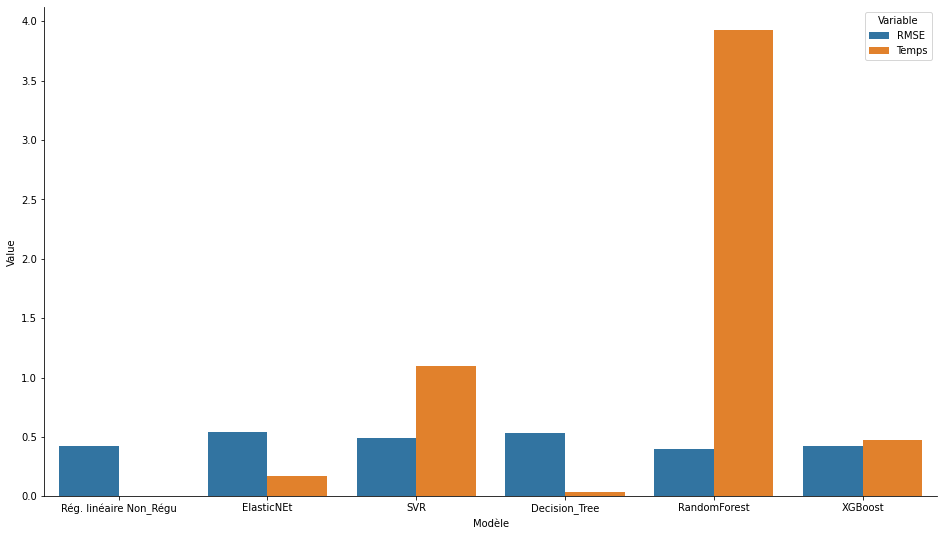

In [69]:
fig, ax1 = plt.subplots(figsize=(16, 9))
tidy = resultat.melt(id_vars='Modèle').rename(columns=str.title)
sns.barplot(x='Modèle', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

## Feature Selection

In [200]:
from boruta import BorutaPy
clf = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=5)

trans = BorutaPy(clf, random_state=42, verbose=2)
sel = trans.fit_transform(X.values, Y['GHGEmissions_log10'].values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	42
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	42
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	42
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	42
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	42
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	42
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	42
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	4
Rejected: 	42
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	3
Reject

In [201]:
trans.ranking_

array([21,  1,  1,  1,  1, 32, 40,  2,  1, 45,  6,  1,  5, 10, 18,  1, 40,
       37, 15,  1,  1, 11, 45, 40, 13, 34, 32, 42, 25, 32,  8, 29,  6, 45,
       20, 27, 12, 37, 35, 26, 28, 29,  9, 42, 24, 16, 23, 22, 13, 17, 36,
       19,  3,  1,  1,  1,  4])

In [202]:
feature_df = pd.DataFrame(X.columns.tolist(), columns=['features'])
feature_df['rank']=trans.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % trans.n_features_)
print (feature_df.head(trans.n_features_))



 Top 12 features:
                             features  rank
0         PrimaryPropertyType_Science     1
1                      NumberofFloors     1
2                            Latitude     1
3                           Longitude     1
4            BuildingType_Multifamily     1
5                  RatioLargestUseGFA     1
6                                 Age     1
7                 Outlier_Low Outlier     1
8                   RatioSecondUseGFA     1
9      PrimaryPropertyType_Healthcare     1
10      LargestPropertyUseType_Office     1
11  LargestPropertyUseType_Healthcare     1


In [203]:
features = feature_df.head(trans.n_features_)['features'].values.tolist()

Cette fois Boruta nous sort que 12 features importantes au lieu de 16 comme précemmetn

## Tester uniquement avec les variables séléctionnées par boruta

On utilisera l'algorithme RandomForest et XgBoost afin de comparer nos valeurs

In [204]:
X_train_boruta= X_train[features].copy()
X_test_boruta= X_test[features].copy()

### RANDOM FOREST 

In [205]:
resultat[resultat['Modèle']=='RandomForest']

,Modèle,RMSE,Temps
4,RandomForest,0.402,5.940


In [206]:
#pour mesurer le temps
deb_rf = time.time()
# Define the model
rf = RandomForestRegressor(n_estimators = 200 ,  random_state = 0)

# Fit the model
rf.fit(X_train_boruta,Y_train)

#Predicting using test set 
y_pred = rf.predict(X_test_boruta)
#time à la fin
fin_rf = time.time()

# Printing the metrics
mae_rf = mean_absolute_error(Y_test, y_pred)
mse_rf = mean_squared_error(Y_test, y_pred)
r2_rf = r2_score(Y_test, y_pred)
rmse_rf = sqrt(mse_rf)

#durée d'exécution
time_rf = fin_rf - deb_rf

In [207]:
print("RMSE: ",rmse_rf,"temps : ",time_rf)

RMSE:  0.4173651510124148 temps :  3.6438844203948975


Sur les tests : 

| AVANT/APRES  | RMSE          | TEMPS |
| :--------------- |:---------------:| -----:|
| Avant  |    0.402       |  5.940 |
| Apres  | 0.417 |  3.643 |


In [208]:
scores = cross_val_score(rf, X_train_boruta, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE RF',np.abs(scores.mean()))

RMSE RF 0.1851713201740701


Cross-validation : 


RMSE RF avant : 0.175

RMSE RF après : 0.185

### XGBOOST

In [209]:
resultat[resultat['Modèle']=='XGBoost']

,Modèle,RMSE,Temps
5,XGBoost,0.427,0.462


In [210]:
#pour mesurer le temps
deb_xgb = time.time()
# Define the model
xgb = XGBRegressor()

# Fit the model
xgb.fit(X_train_boruta, Y_train)

#Predicting using test set
y_pred = xgb.predict(X_test_boruta)
#time à la fin
fin_xgb = time.time()

# Printing the metrics
mae_xgb = mean_absolute_error(Y_test, y_pred)
mse_xgb = mean_squared_error(Y_test, y_pred)
r2_xgb = r2_score(Y_test, y_pred)
rmse_xgb = sqrt(mse_xgb)

#durée d'exécution
time_xgb = fin_xgb - deb_xgb

In [211]:
print("RMSE: ",rmse_xgb,"temps : ",time_xgb)

RMSE:  0.429478914706281 temps :  0.2684636116027832


Sur les tests : 

| AVANT/APRES  | RMSE          | TEMPS |
| :--------------- |:---------------:| -----:|
| Avant  |   0.427        |  0.462 |
| Apres  |	0.755 |  0.449 |


In [212]:
scores = cross_val_score(xgb, X_train_boruta, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE XGB',np.abs(scores.mean()))

RMSE XGB 0.19721213660031886


Cross-validation :

RMSE XGB  avant : 0.188

RMSE XGB  après : 0.197


## Recherche des meilleurs paramètres via Gridsearch

In [213]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [ 14, 15, 16],
    'n_estimators': [50, 100, 200, 300, 400, 500]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='neg_mean_squared_error', cv = 3, n_jobs = -1, verbose = 0)

In [214]:
grid_search.fit(X_train_boruta, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [215]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 500}

In [216]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=14,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [226]:
#pour mesurer le temps
deb_rf = time.time()
# Define the model
rf = RandomForestRegressor(bootstrap= True, 
                           max_depth= 50, min_samples_leaf= 1,
                           min_samples_split= 14, n_estimators= 500)

# Fit the model
rf.fit(X_train_boruta,Y_train)

#Predicting using test set 
y_pred = rf.predict(X_test_boruta)
#time à la fin
fin_rf = time.time()

# Printing the metrics
mae_rf = mean_absolute_error(Y_test, y_pred)
mse_rf = mean_squared_error(Y_test, y_pred)
r2_rf = r2_score(Y_test, y_pred)
rmse_rf = sqrt(mse_rf)

#durée d'exécution
time_rf = fin_rf - deb_rf

In [227]:
print("RMSE: ",rmse_rf,"temps : ",time_rf)

RMSE:  0.45219015761544634 temps :  6.74488091468811


Sur les tests : 

| AVANT/APRES  | RMSE          | TEMPS |
| :--------------- |:---------------:| -----:|
| Avant  |    0.402       |  5.940 |
| Apres  | 0.417 |  3.643 |
| GridSearch  | 0.452  |  6.744 |

In [219]:
scores = cross_val_score(rf, X_train_boruta, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE RF',np.abs(scores.mean()))

RMSE RF 0.20574829781780118


Cross-validation :

RMSE RF avant : 0.175

RMSE RF après : 0.185

RMSE RF via GridsearchCV : 0.205

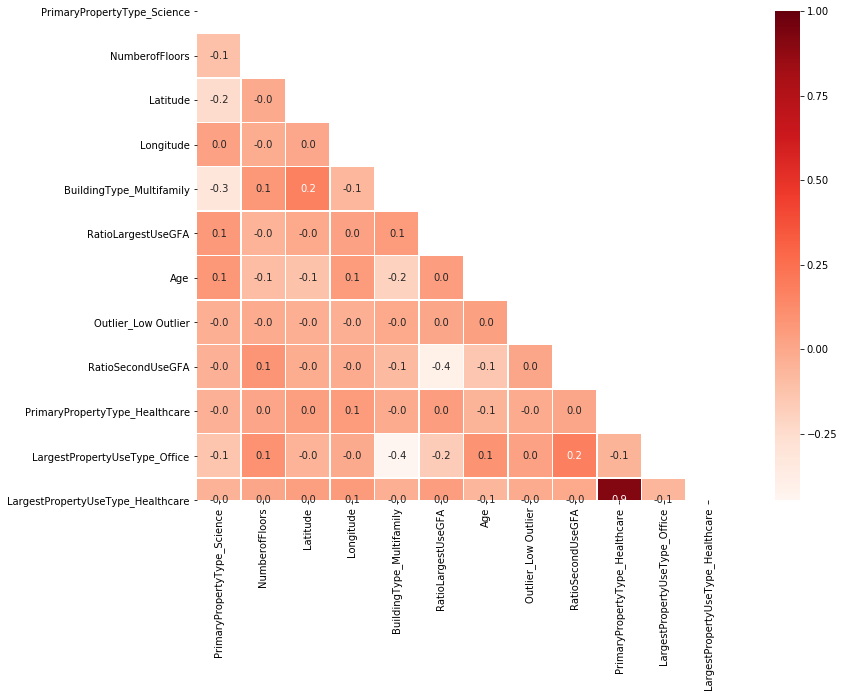

In [247]:
# Ajout Target Y[EMISION]
corr = data_analyse[features].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 9))
plt.xticks(rotation=45)
sns.heatmap(corr, annot = True,cmap="Reds", mask = mask, fmt='.1f', linewidths=.5, square=True, vmax=1)

Text(0, 0.5, 'y_pred')

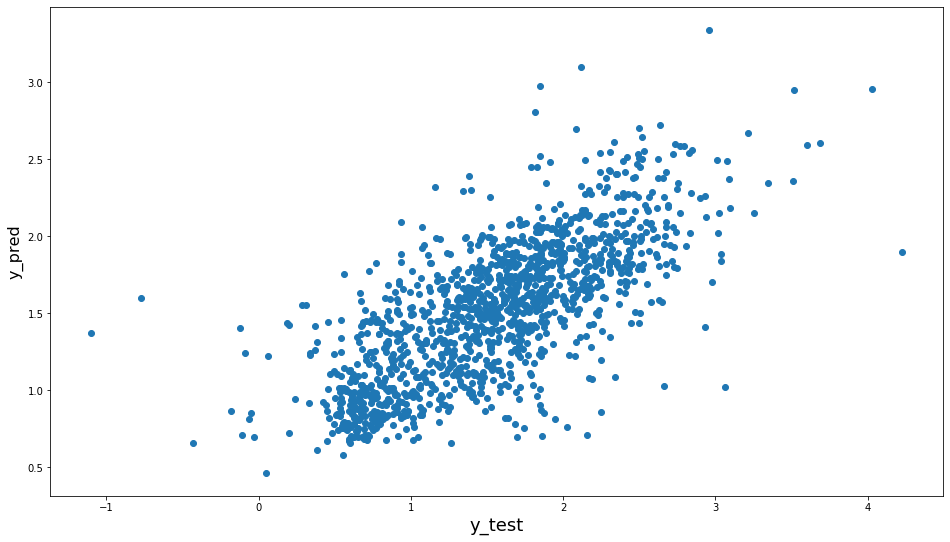

In [220]:
plt.figure(figsize=(16,9))
plt.scatter(Y_test, y_pred)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

Text(0, 0.5, 'y_pred')

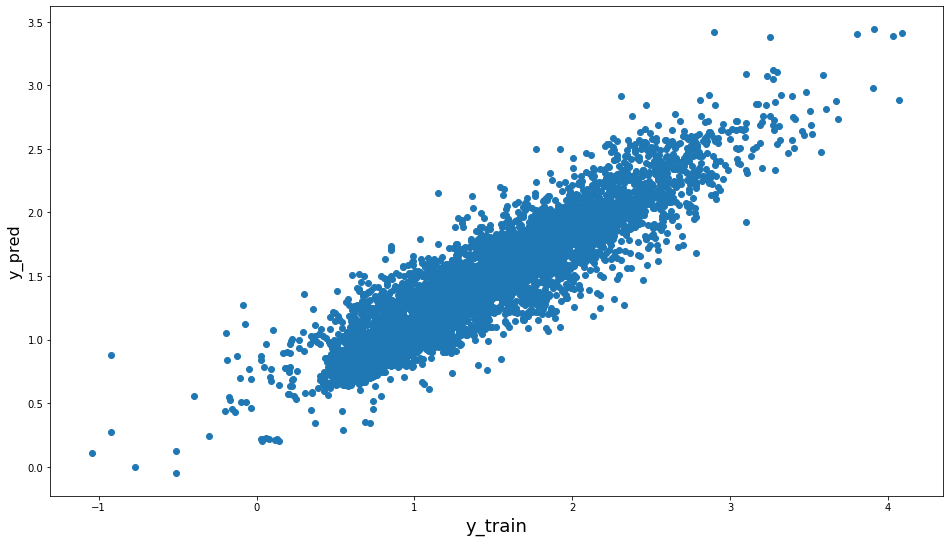

In [221]:
plt.figure(figsize=(16,9))
plt.scatter(Y_train, rf.predict(X_train_boruta))
plt.xlabel('y_train', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

In [222]:
coefficients = abs(grid_search.best_estimator_.feature_importances_)
liste_coefs = pd.concat((pd.DataFrame(X_train_boruta.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

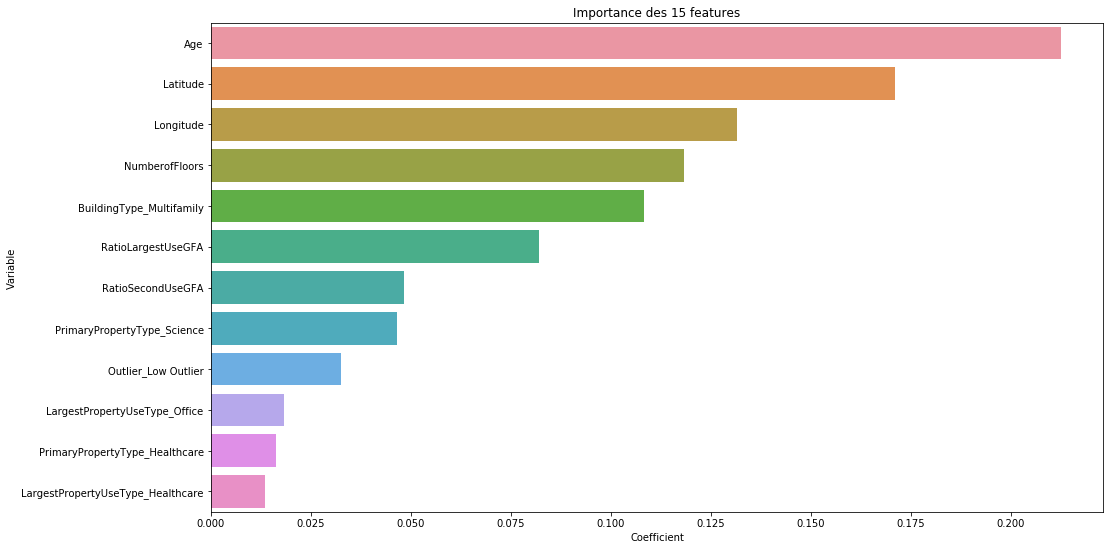

In [223]:
plt.figure(figsize=(16,9))
plt.title('Importance des 15 features')
sns.barplot(y = liste_coefs['Variable'].head(15),
            x = liste_coefs['Coefficient'].head(15))
plt.show()

## Shape Value 

In [224]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_boruta)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_boruta.iloc[0,:])

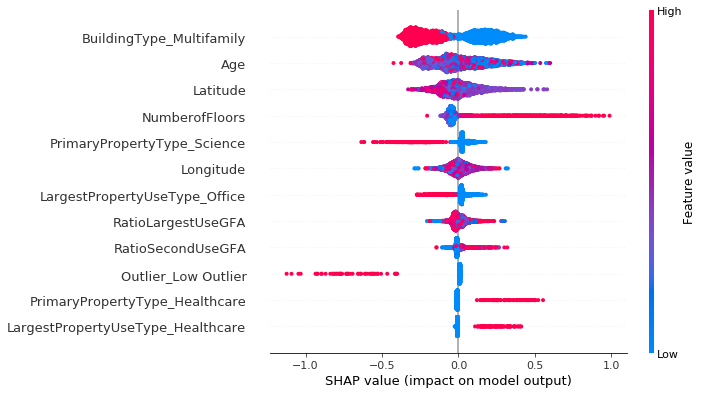

In [225]:
shap.summary_plot(shap_values, X_train_boruta)

# Intérêt de l'ENERGY STAR SCORE 

Dernière partie est de savoir si notre Energie Star score est important pour nos modèle et quelle est l'impact de celui-ci

In [274]:
data_analyse = pd.read_csv('data/data_analyse.csv')

In [275]:
data_analyse.drop('Unnamed: 0', axis=1, inplace=True)

In [276]:
data_analyse = shuffle(data_analyse)

In [277]:
data_analyse.dropna(subset=['ENERGYSTARScore'],inplace=True)

In [278]:
data_model = data_analyse.copy()
X = data_model.copy().drop(['SiteEnergyUseWN_log', 'GHGEmissions_log10',], axis=1)
Y = data_model.copy()[{'SiteEnergyUseWN_log', 'GHGEmissions_log10'}]

In [279]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y['SiteEnergyUseWN_log'], test_size = 0.2, random_state = 23)

In [280]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4056, 58), (4056,), (1014, 58), (1014,))

In [281]:
X_train_numerical =X_train[['ENERGYSTARScore','NumberofBuildings','NumberofFloors','Latitude','Longitude','Age' , 'RatioLargestUseGFA','RatioSecondUseGFA', 'RatioThirdUseGFA']].columns 
X_test_numerical =X_test[['ENERGYSTARScore','NumberofBuildings','NumberofFloors','Latitude','Longitude','Age' , 'RatioLargestUseGFA','RatioSecondUseGFA', 'RatioThirdUseGFA']].columns 

In [282]:
scaler = RobustScaler()
X_train[X_train_numerical] = scaler.fit_transform(X_train[X_train_numerical])
X_test[X_test_numerical] = scaler.transform(X_test[X_test_numerical])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

In [284]:
#pour mesurer le temps
deb_rf = time.time()
# Define the model
rf = RandomForestRegressor(bootstrap= True, 
                           max_depth= 50, min_samples_leaf= 1,
                           min_samples_split= 14, n_estimators= 400)

# Fit the model
rf.fit(X_train,Y_train)

#Predicting using test set 
y_pred = rf.predict(X_test)
#time à la fin
fin_rf = time.time()

# Printing the metrics
mae_rf = mean_absolute_error(Y_test, y_pred)
mse_rf = mean_squared_error(Y_test, y_pred)
r2_rf = r2_score(Y_test, y_pred)
rmse_rf = sqrt(mse_rf)

#durée d'exécution
time_rf = fin_rf - deb_rf

In [285]:
print("MAE : ",mae_rf, "R2:",r2_rf,"RMSE: ",rmse_rf,"temps : ",time_rf)

MAE :  0.47807556048669997 R2: 0.6708926450015613 RMSE:  0.6333491838139659 temps :  6.651721000671387


In [286]:
scores = cross_val_score(rf, X_train, Y_train, cv=5,
                        scoring='neg_mean_squared_error')
print('RMSE RF',np.abs(scores.mean()))

RMSE RF 0.45713364192489775


In [293]:
clf = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=5)

trans = BorutaPy(clf, random_state=42, verbose=2)
sel = trans.fit_transform(X.values, Y['SiteEnergyUseWN_log'].values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	4
Rejected: 	37
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	4
Rejected: 	37
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	4
Rejected: 	37
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	4
Rejected: 	37
Iteration: 	12 / 100
Confirmed: 	19
Tentative: 	2
Rejected: 	37
Iteration: 	13 / 100
Confirmed: 	19
Tentative: 	2
Rejected: 	37
Iteration: 	14 / 100
Confirmed: 	19
Tentative: 	2
Rejected: 	37
Iteration: 	15 / 100
Confirmed: 	19
Tentative: 	2
Rejected: 	37
Iteration: 	16 / 100
Confirmed: 	20
Tentative: 	0
Reject

In [296]:
trans.ranking_

array([ 4,  1,  1,  1,  1,  1,  1, 35,  6,  1, 15,  6,  1,  1, 18,  2,  1,
       31, 10,  1,  1,  1, 37,  4, 26,  1,  3, 29, 37, 27, 34, 13, 28,  1,
       37, 14,  9, 20, 31, 23, 17, 24, 21, 21, 37, 33, 11, 18, 25,  8, 12,
       30, 16,  1,  1,  1,  1,  1])

In [297]:
feature_df = pd.DataFrame(X.columns.tolist(), columns=['features'])
feature_df['rank']=trans.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % trans.n_features_)
print (feature_df.head(trans.n_features_))


 Top 20 features:
                                features  rank
0                       RatioThirdUseGFA     1
1      LargestPropertyUseType_Healthcare     1
2            LargestPropertyUseType_Food     1
3     LargestPropertyUseType_Residential     1
4            PrimaryPropertyType_Science     1
5                      RatioSecondUseGFA     1
6             PrimaryPropertyType_Office     1
7         PrimaryPropertyType_Healthcare     1
8          LargestPropertyUseType_Office     1
9                  CouncilDistrictCode_7     1
10  SecondLargestPropertyUseType_Parking     1
11                                   Age     1
12                    RatioLargestUseGFA     1
13           BuildingType_Nonresidential     1
14              BuildingType_Multifamily     1
15                             Longitude     1
16                              Latitude     1
17                       ENERGYSTARScore     1
18                        NumberofFloors     1
19                   Outlier_Low Outlier 

In [287]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [ 14, 15, 16],
    'n_estimators': [50, 100, 200, 300, 400, 500]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='neg_mean_squared_error', cv = 3, n_jobs = -1, verbose = 0)

In [288]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [289]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 200}

In [290]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=14,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [294]:
coefficients = abs(grid_search.best_estimator_.feature_importances_)
liste_coefs = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

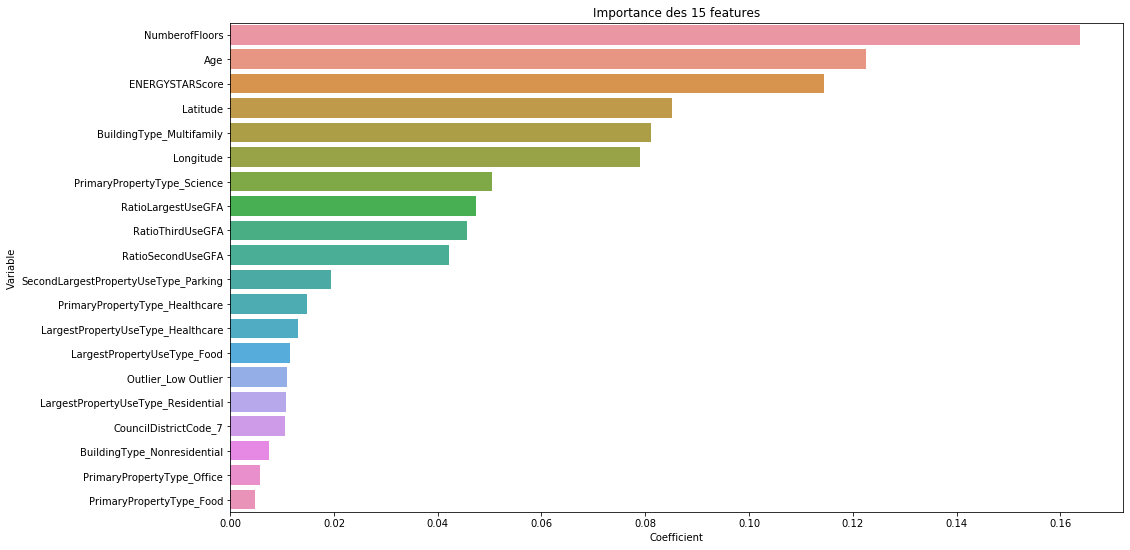

In [298]:
plt.figure(figsize=(16,9))
plt.title('Importance des 15 features')
sns.barplot(y = liste_coefs['Variable'].head(20),
            x = liste_coefs['Coefficient'].head(20))
plt.show()

BORUTA et gridsearch estime l'importance de notre Energie Star score au niveau 3 des features importantes
Notre RMSE avec l'energie star est de 0.457 tandis que sans elle est de 0.534